# Revisiting problematic lines

Some of the line maps have discontinuities between the ABCD fields. In this notebook, we are going to work out what is wrong and fix it.

## [O I] 6300 line 

This has a sky component, which is probably causing the problem. However, we ought to be able to remove it since the LMC is redshifted by over 200 km/s.

Also, we can use the ratio of 6363/6300 in the faint parts to guide us. 

In [48]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cmasher as cm
from mpdaf.obj import Cube
import regions
import sys
import warnings
sys.path.append("../lib")
import moments
import extract

import astropy.units as u
import astropy.constants as const

sns.set_context("talk")
sns.set_color_codes()

Start off by using the subcubes, as we did in the 05-04 notebook

In [21]:
labels = "ABCD"
csub = {
    label: 
    Cube(f"../big-data/lmc-30dor-{label}-subcube-62-71-contsub.fits") 
    for label in labels
}
corig = {
    label: 
    Cube(f"../big-data/lmc-30dor-{label}-subcube-62-71.fits") 
    for label in labels
}

In [25]:
C_KMS = const.c.to(u.km/u.s).value

def wavlimits(wav0, vlim=[100.0, 300.0]):
    wav1 = wav0 * (1.0 + vlim[0] / C_KMS)
    wav2 = wav0 * (1.0 + vlim[1] / C_KMS)
    return wav1, wav2
      

In [27]:
oi_window_median = {label: cube.select_lambda(6250, 6400).median(axis=(1, 2)) for label, cube in csub.items()}

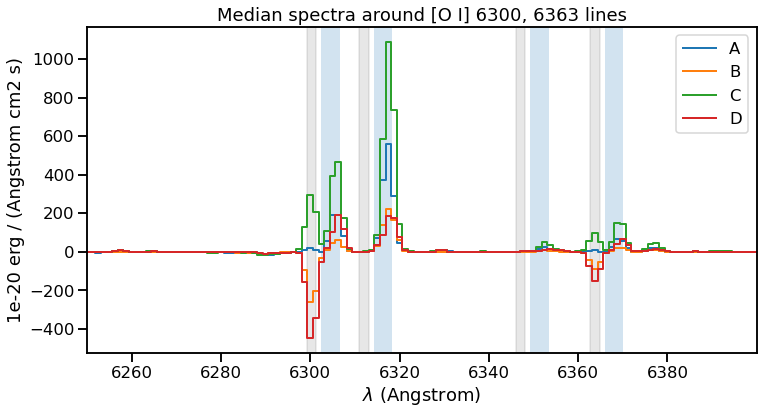

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
for label, spec in oi_window_median.items():
    spec.plot(label=label, linewidth=2)

#wav1, wav2 = wavlimits(6300.30)
for wav0 in 6300.30, 6363.78, 6312.06, 6347.11:
    ax.axvspan(*wavlimits(wav0), alpha=0.2)
    ax.axvspan(*wavlimits(wav0, vlim=[-50, 50]), alpha=0.1, color="k")
ax.legend()
ax.set_title("Median spectra around [O I] 6300, 6363 lines")
...;

So, a few things:

1. This is the median of the BG-subtracted cube of each of the ABCD fields. I originally tried with the mean, but that was weird for the BG-subtracted ones (presumably there are a few pixels that are problematic, mainly where there is a bright star). 
2. It looks like in fields B and D the sky has been oversubtracted, whereas in A and C it has been undersubtracted. 
3. I am showing the window for velocity ranges of [-50, 50] (gray) and [100, 300] (blue) for the O I, S III and Si II lines. 
4. The latter is the default window that I have been using for line extraction, and it looks like it is missing a lot of the flux on the red side of the line profile.



So the first solution to try is just to use a better extraction window. Maybe [150, 400]

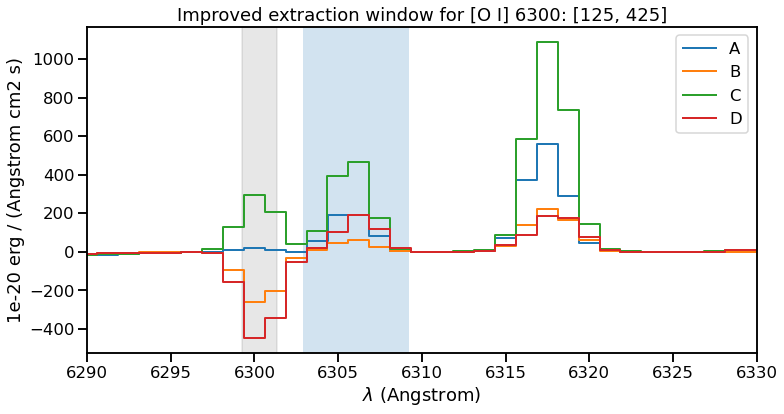

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
for label, spec in oi_window_median.items():
    spec.plot(label=label, linewidth=2)

newvlim = [125, 425]
for wav0 in 6300.30,:
    ax.axvspan(*wavlimits(wav0, vlim=newvlim), alpha=0.2)
    ax.axvspan(*wavlimits(wav0, vlim=[-50, 50]), alpha=0.1, color="k")
ax.legend()
ax.set_title(f"Improved extraction window for [O I] 6300: {newvlim}")
ax.set(
    xlim=[6290, 6330],
)
...;

### Calculate moments with new extraction window

In [39]:
oimoms = {
    label:
    moments.find_moments(cube.select_lambda(*wavlimits(wav0, vlim=newvlim)))
    for label, cube in csub.items()
}

../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


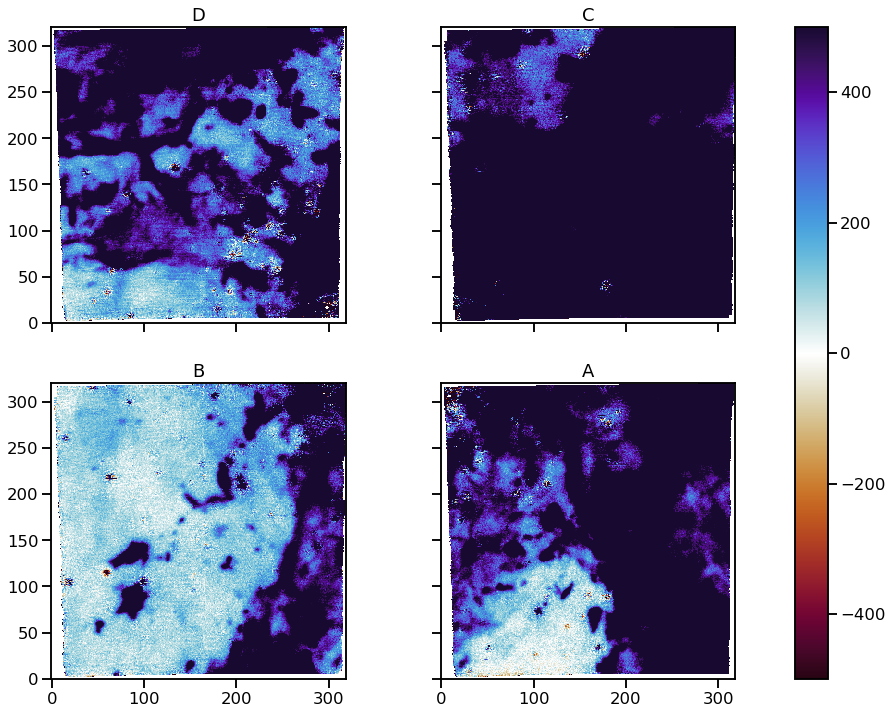

In [121]:
scale = 500
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
oimoms["D"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[0, 0])
axes[0, 0].set_title("D")
oimoms["C"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[0, 1])
axes[0, 1].set_title("C")
oimoms["B"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[1, 0])
axes[1, 0].set_title("B")
im = oimoms["A"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[1, 1])
axes[1, 1].set_title("A")
fig.colorbar(im, ax=axes)
...;

Yay, all positive now!  (With the exception of a few stars, which presumably have the absorption line).

We will look at the velocities too to see if they are improved any:

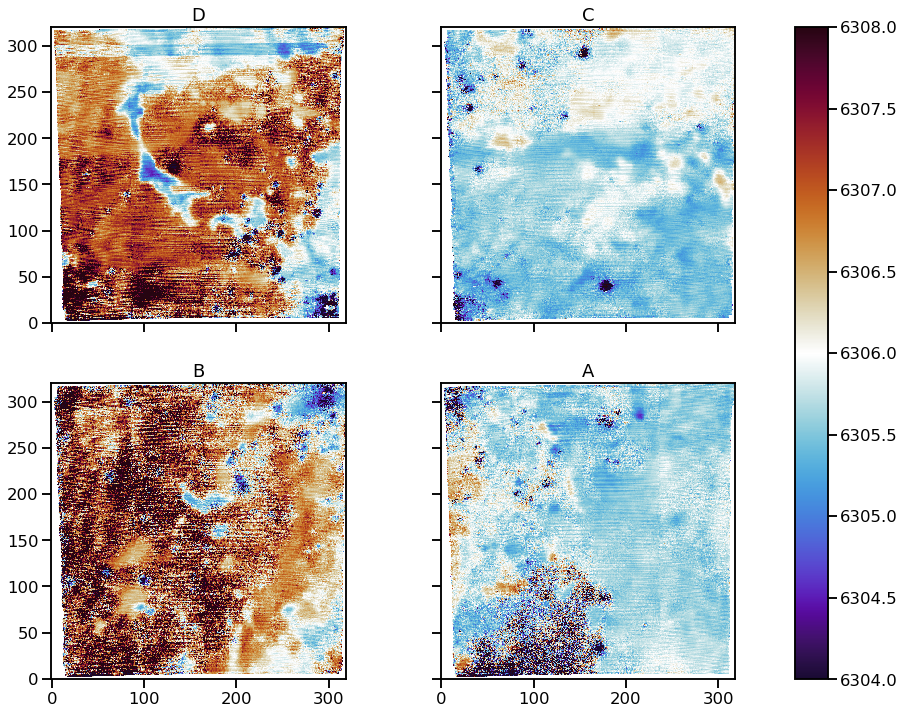

In [66]:
kws = dict(vmin=6304, vmax=6308, cmap=cm.fusion_r)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
oimoms["D"][1].plot(ax=axes[0, 0], **kws)
axes[0, 0].set_title("D")
oimoms["C"][1].plot(ax=axes[0, 1], **kws)
axes[0, 1].set_title("C")
oimoms["B"][1].plot(ax=axes[1, 0], **kws)
axes[1, 0].set_title("B")
im = oimoms["A"][1].plot(ax=axes[1, 1], **kws)
axes[1, 1].set_title("A")
fig.colorbar(im, ax=axes)
...;

Yes, that looks a lot better too. Note that the the units are still wavelength, not velocity.

In [75]:
medlam = np.mean(oimoms["A"][1].data)
medlam

6305.768145736317

We can convert to velocity to compare with our new window.

In [77]:
C_KMS * (medlam - wav0) / wav0, newvlim

(260.195363870389, [125, 425])

So that is pretty well centered.  There does still seem to be a little bit of an effect of the sky still. For instance, there looks like there is a discontinuity between C and D

In [78]:
np.mean(oimoms["A"][2].data)

1.1395981390299599

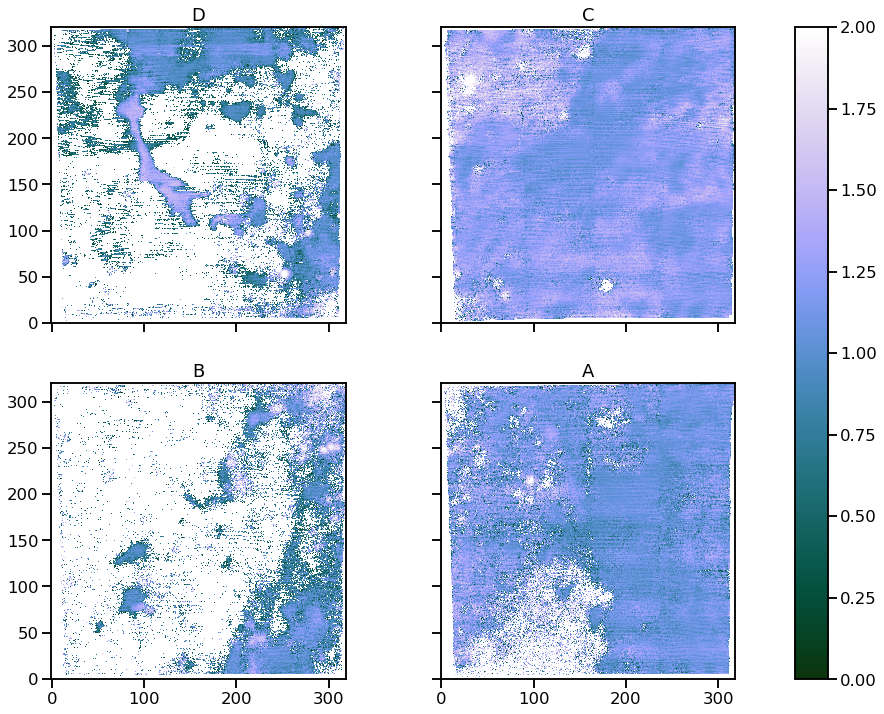

In [82]:
kws = dict(vmin=0, vmax=2, cmap=cm.horizon)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
oimoms["D"][2].plot(ax=axes[0, 0], **kws)
axes[0, 0].set_title("D")
oimoms["C"][2].plot(ax=axes[0, 1], **kws)
axes[0, 1].set_title("C")
oimoms["B"][2].plot(ax=axes[1, 0], **kws)
axes[1, 0].set_title("B")
im = oimoms["A"][2].plot(ax=axes[1, 1], **kws)
axes[1, 1].set_title("A")
fig.colorbar(im, ax=axes)
...;

### Repeat for a window that isolates the sky

In [83]:
skyvlim = [-100, 100]
oiskymoms = {
    label:
    moments.find_moments(cube.select_lambda(*wavlimits(wav0, vlim=skyvlim)))
    for label, cube in csub.items()
}

../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


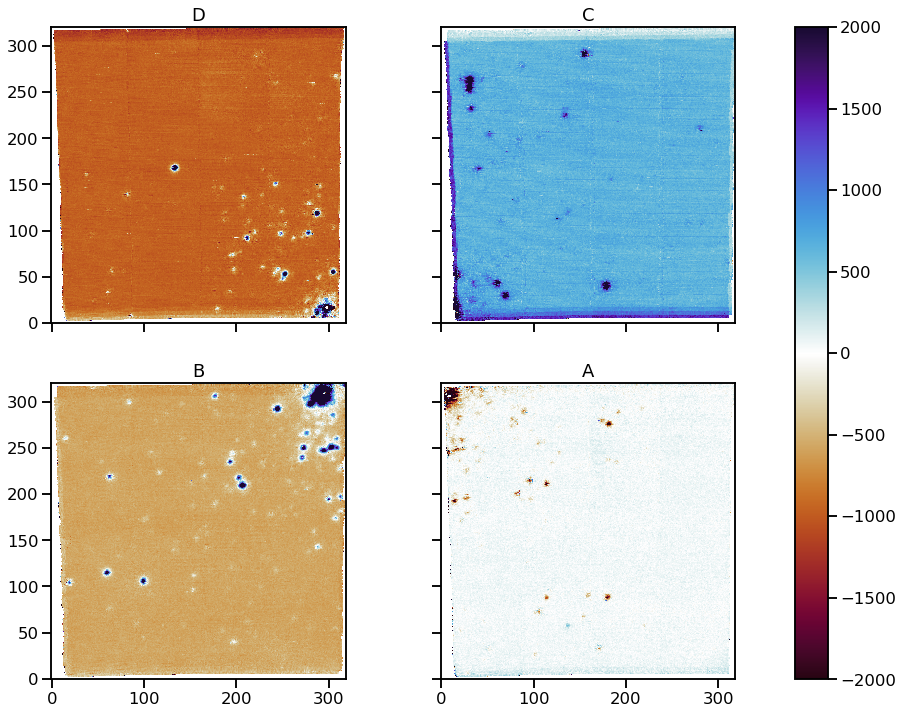

In [85]:
scale = 2000
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
oiskymoms["D"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[0, 0])
axes[0, 0].set_title("D")
oiskymoms["C"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[0, 1])
axes[0, 1].set_title("C")
oiskymoms["B"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[1, 0])
axes[1, 0].set_title("B")
im = oiskymoms["A"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[1, 1])
axes[1, 1].set_title("A")
fig.colorbar(im, ax=axes)
...;

This all looks very uniform in each field.  One idea would be to fit a Gaussian to the median of each field and subtract it.

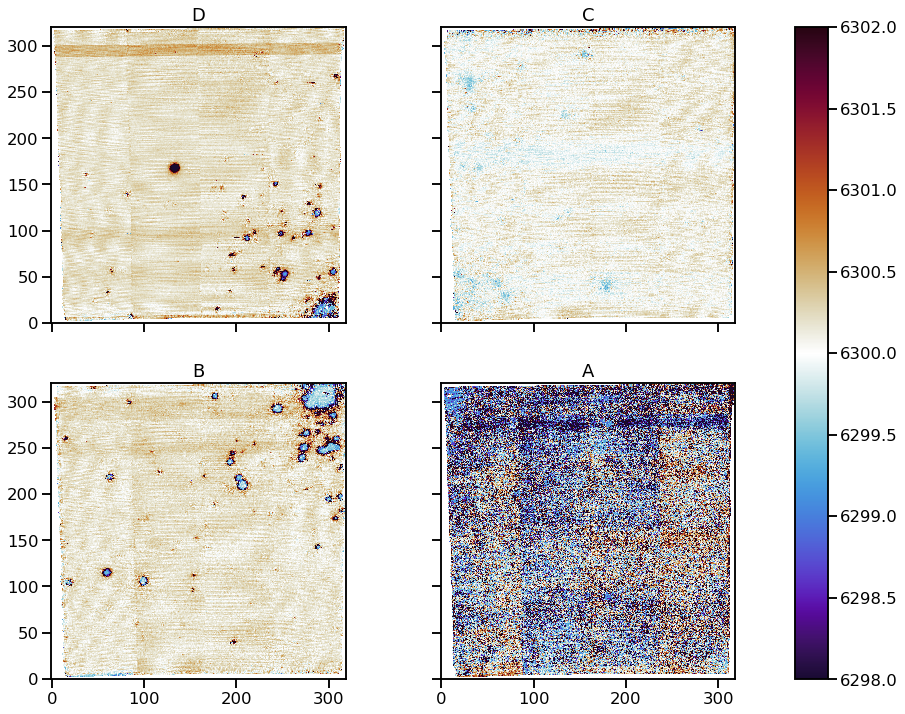

In [133]:
kws = dict(vmin=6298, vmax=6302, cmap=cm.fusion_r)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
oiskymoms["D"][1].plot(ax=axes[0, 0], **kws)
axes[0, 0].set_title("D")
oiskymoms["C"][1].plot(ax=axes[0, 1], **kws)
axes[0, 1].set_title("C")
oiskymoms["B"][1].plot(ax=axes[1, 0], **kws)
axes[1, 0].set_title("B")
im = oiskymoms["A"][1].plot(ax=axes[1, 1], **kws)
axes[1, 1].set_title("A")
fig.colorbar(im, ax=axes)
...;

### Fit the Sky component with a Gaussian

In [86]:
from astropy.modeling import models, fitting
fitter = fitting.LevMarLSQFitter()

In [95]:
oi_sky_median = {label: cube.select_lambda(wav0 - 4.0, wav0 + 4.0).median(axis=(1, 2)) for label, cube in csub.items()}

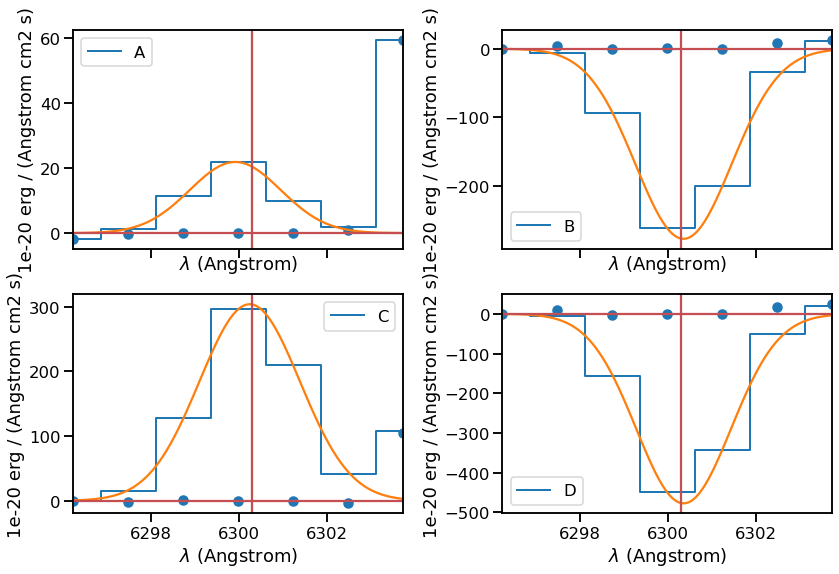

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=False)

wavs = spec.wave.coord()
m = wavs <= wav0 + 2.0
finewavs = np.linspace(wavs.min(), wavs.max(), 100)

skygaus = {}
for ax, [label, spec] in zip(axes.flat, oi_sky_median.items()):
    spec.plot(label=label, linewidth=2, ax=ax)
    
    g = models.Gaussian1D(amplitude=spec.data[m].max(), mean=wav0, stddev=1.0)
    g = fitter(g, wavs[m], spec.data[m])
    skygaus[label] = g
    ax.plot(finewavs, g(finewavs))
    residuals = spec.data - g(wavs)
    ax.scatter(wavs, residuals)
    ax.legend()
    ax.axvline(wav0, color="r")
    ax.axhline(0, color="r")
fig.tight_layout()
...;

The fits look like they worked very well. The residuals are shown by the blue dots.  We get positive residual on the right edge because of the nebular component starting to rise, which is totally expected. 

We can look at the fitted models:

In [111]:
skygaus

{'A': <Gaussian1D(amplitude=21.84086439, mean=6299.92028242, stddev=1.03276637)>,
 'B': <Gaussian1D(amplitude=-277.03868851, mean=6300.35371247, stddev=1.09454624)>,
 'C': <Gaussian1D(amplitude=303.92848546, mean=6300.24853284, stddev=1.14380994)>,
 'D': <Gaussian1D(amplitude=-477.32568718, mean=6300.35597552, stddev=1.07702807)>}

So it looks like A was observed on a different date from the others, since the mean wavelength is significantly bluer. If we could be bothered, it would be good to calculate the heliocentric correction for each observing date to make sure that these values make sense. 

Now compare with the extraction window again:

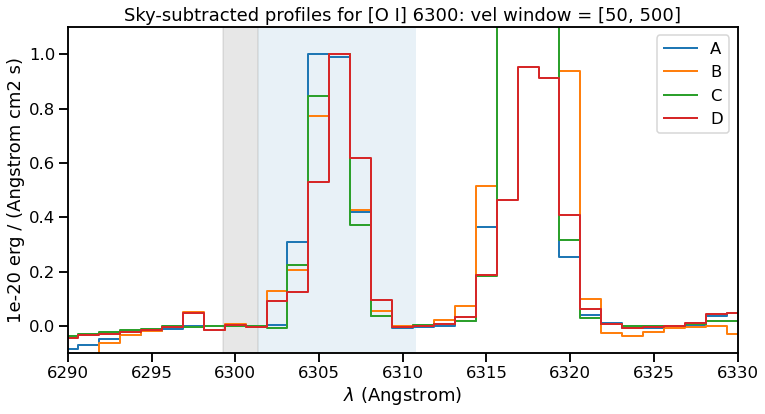

In [116]:
fig, ax = plt.subplots(figsize=(12, 6))
for label, spec in oi_window_median.items():
    newspec = spec.copy()
    newspec.data -= skygaus[label](spec.wave.coord())
    norm = np.max(newspec.subspec(*wavlimits(wav0, vlim=newvlim)).data)
    newspec /= norm
    newspec.plot(label=label, linewidth=2)

newvlim = [50, 500]
for wav0 in 6300.30,:
    ax.axvspan(*wavlimits(wav0, vlim=newvlim), alpha=0.1)
    ax.axvspan(*wavlimits(wav0, vlim=[-50, 50]), alpha=0.1, color="k")
ax.legend()
ax.set_title(f"Sky-subtracted profiles for [O I] 6300: vel window = {newvlim}")
ax.set(
    xlim=[6290, 6330],
    ylim=[-0.1, 1.1],
)
...;

In [117]:
cssub = {}
for label in "ABCD":
    newcube = csub[label].copy()
    skyspec = skygaus[label](cube.wave.coord())
    newcube.data -= skyspec[:, None, None]
    cssub[label] = newcube

### Repeat the moment calculation with the sky-subtracted cube

In [118]:
oimomss = {
    label:
    moments.find_moments(cube.select_lambda(*wavlimits(wav0, vlim=newvlim)))
    for label, cube in cssub.items()
}

../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


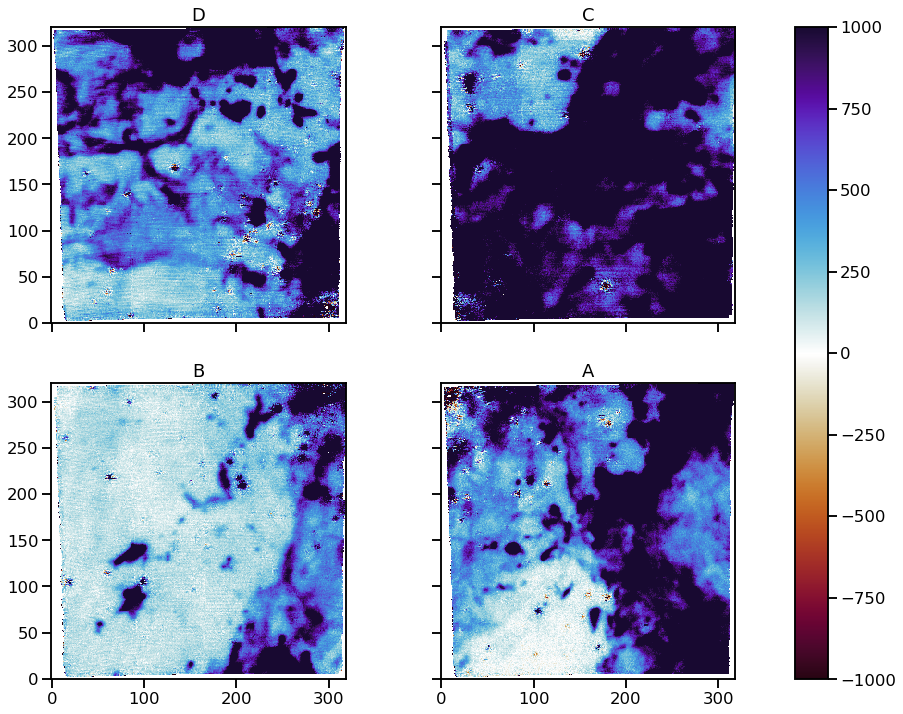

In [124]:
scale = 1000
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
oimomss["D"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[0, 0])
axes[0, 0].set_title("D")
oimomss["C"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[0, 1])
axes[0, 1].set_title("C")
oimomss["B"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[1, 0])
axes[1, 0].set_title("B")
im = oimomss["A"][0].plot(vmin=-scale, vmax=scale, cmap=cm.fusion, ax=axes[1, 1])
axes[1, 1].set_title("A")
fig.colorbar(im, ax=axes)
...;

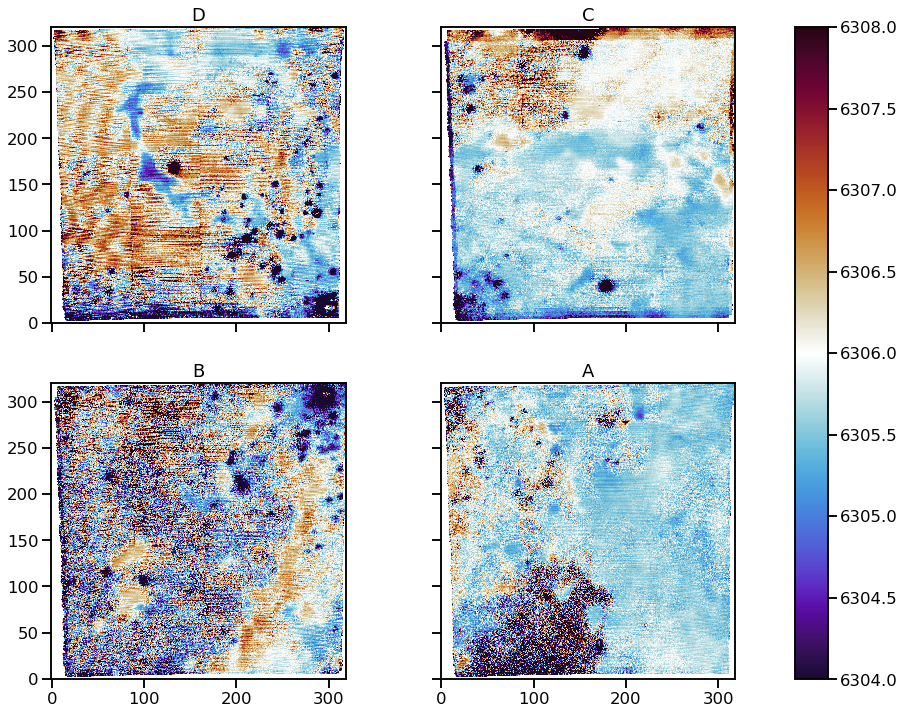

In [131]:
kws = dict(vmin=6304, vmax=6308, cmap=cm.fusion_r)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
oimomss["D"][1].plot(ax=axes[0, 0], **kws)
axes[0, 0].set_title("D")
oimomss["C"][1].plot(ax=axes[0, 1], **kws)
axes[0, 1].set_title("C")
oimomss["B"][1].plot(ax=axes[1, 0], **kws)
axes[1, 0].set_title("B")
im = oimomss["A"][1].plot(ax=axes[1, 1], **kws)
axes[1, 1].set_title("A")
fig.colorbar(im, ax=axes)
...;

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cm.py:333: FutureWarning: The 'heat' colormap was renamed to 'torch' in v1.6.1 and will be removed in v1.7.
  rgba = self.cmap(x, alpha=alpha, bytes=bytes)


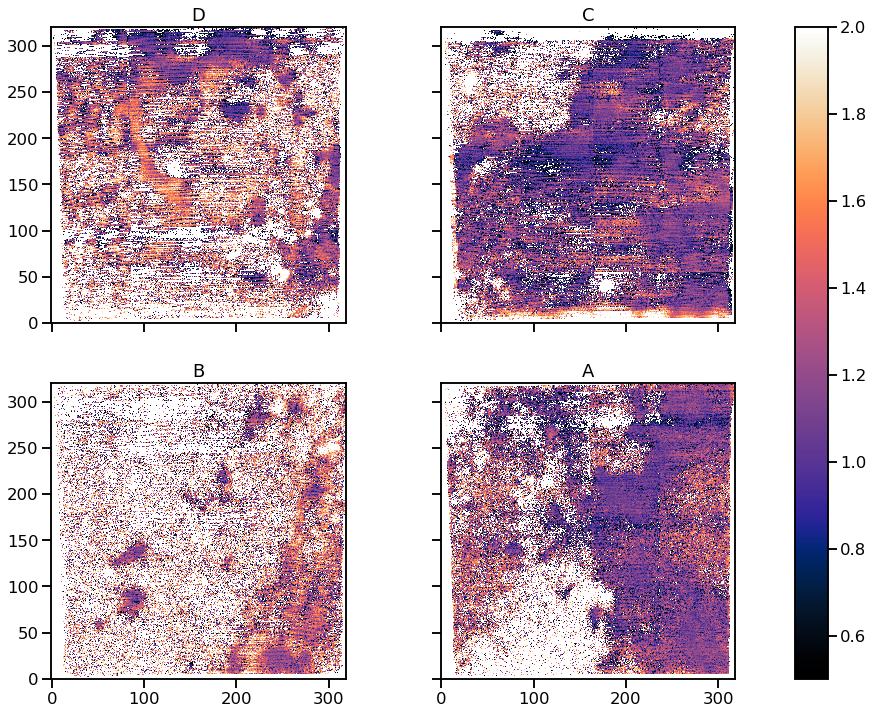

In [132]:
kws = dict(vmin=0.5, vmax=2, cmap=cm.heat)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
oimomss["D"][2].plot(ax=axes[0, 0], **kws)
axes[0, 0].set_title("D")
oimomss["C"][2].plot(ax=axes[0, 1], **kws)
axes[0, 1].set_title("C")
oimomss["B"][2].plot(ax=axes[1, 0], **kws)
axes[1, 0].set_title("B")
im = oimomss["A"][2].plot(ax=axes[1, 1], **kws)
axes[1, 1].set_title("A")
fig.colorbar(im, ax=axes)
...;

These are way better.  The mean and stddev are noisy in the faint parts of course, but we are no lomger seeing the suspicious behavior that we saw before. 

Now we just need to find a way to generalise this.

But first, have a look at subtracting off the sky mean wavelength to see if it eliminates some of the pattern noise. 

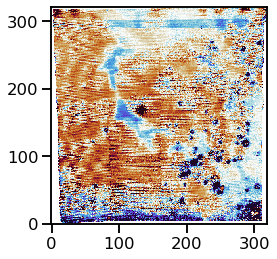

In [137]:
(oimomss["D"][1] - oiskymoms["D"][1]).plot(vmin=3.5, vmax=7.5, cmap=cm.fusion_r)

Does that help? Maybe a bit, but probably not enough to be worth doing.

## Fluorescent O I lines

The 8446 line had a similar problem but to a much smaller degree.